# Heart Disease Classification

## 1. Import modules and data file

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, randint, uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [192]:
data = pd.read_csv("heart.csv")
print("Data is loaded")

Data is loaded


## 2. General Understanding

In [193]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [194]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


(918, 12)

In [195]:
data['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

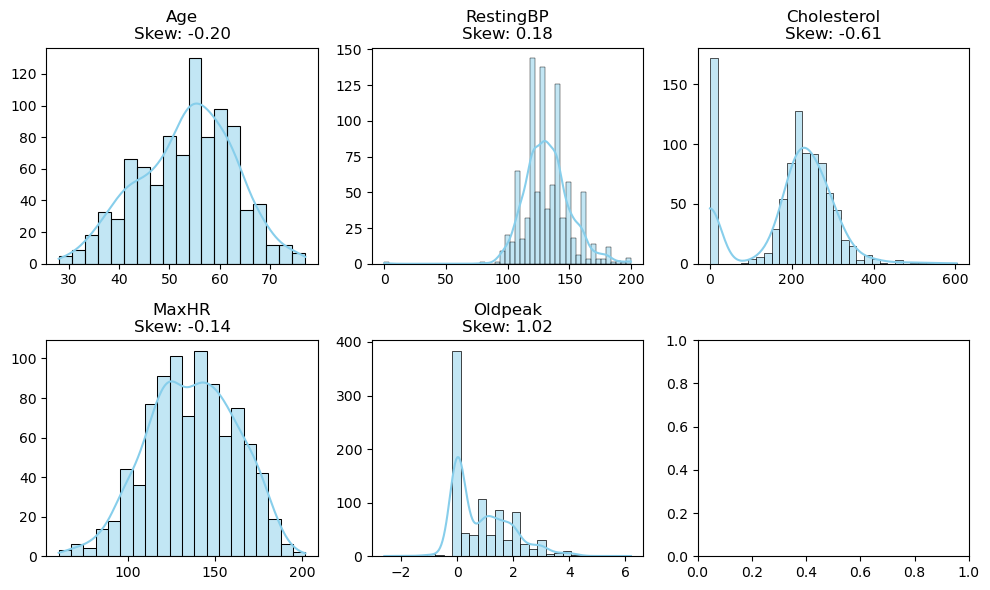

In [196]:
cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()

for i, col in enumerate(cols):
    skew_val = data[col].skew()
    sns.histplot(data[col], kde=True, ax=ax[i], color='skyblue', alpha=0.5)
    ax[i].set_title(f"{col}\nSkew: {skew_val:.2f}")
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Data Cleaning and Feature Engineering

In [197]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [198]:
def label_encode(data):
    encoder = LabelEncoder()
    data['ST_Slope'] = encoder.fit_transform(data['ST_Slope'])
    return data

In [199]:
data = label_encode(data)
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,2,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,1,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,2,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,1,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,1,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,1,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,1,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,1,1


In [200]:
def onehot_encode(data):
    data['ExerciseAngina'] = data['ExerciseAngina'].apply(lambda x:1 if x == 'Y' else 0)
    columns = ['Sex','ChestPainType', 'RestingECG']
    for col in columns:
        dummies = pd.get_dummies(data[col])
        data = pd.concat([data.drop(col, axis=1), dummies], axis=1)

    return data

In [201]:
data = onehot_encode(data)
data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,F,M,ASY,ATA,NAP,TA,LVH,Normal,ST
0,40,140,289,0,172,0,0.0,2,0,False,True,False,True,False,False,False,True,False
1,49,160,180,0,156,0,1.0,1,1,True,False,False,False,True,False,False,True,False
2,37,130,283,0,98,0,0.0,2,0,False,True,False,True,False,False,False,False,True
3,48,138,214,0,108,1,1.5,1,1,True,False,True,False,False,False,False,True,False
4,54,150,195,0,122,0,0.0,2,0,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,0,1.2,1,1,False,True,False,False,False,True,False,True,False
914,68,144,193,1,141,0,3.4,1,1,False,True,True,False,False,False,False,True,False
915,57,130,131,0,115,1,1.2,1,1,False,True,True,False,False,False,False,True,False
916,57,130,236,0,174,0,0.0,1,1,True,False,False,True,False,False,True,False,False


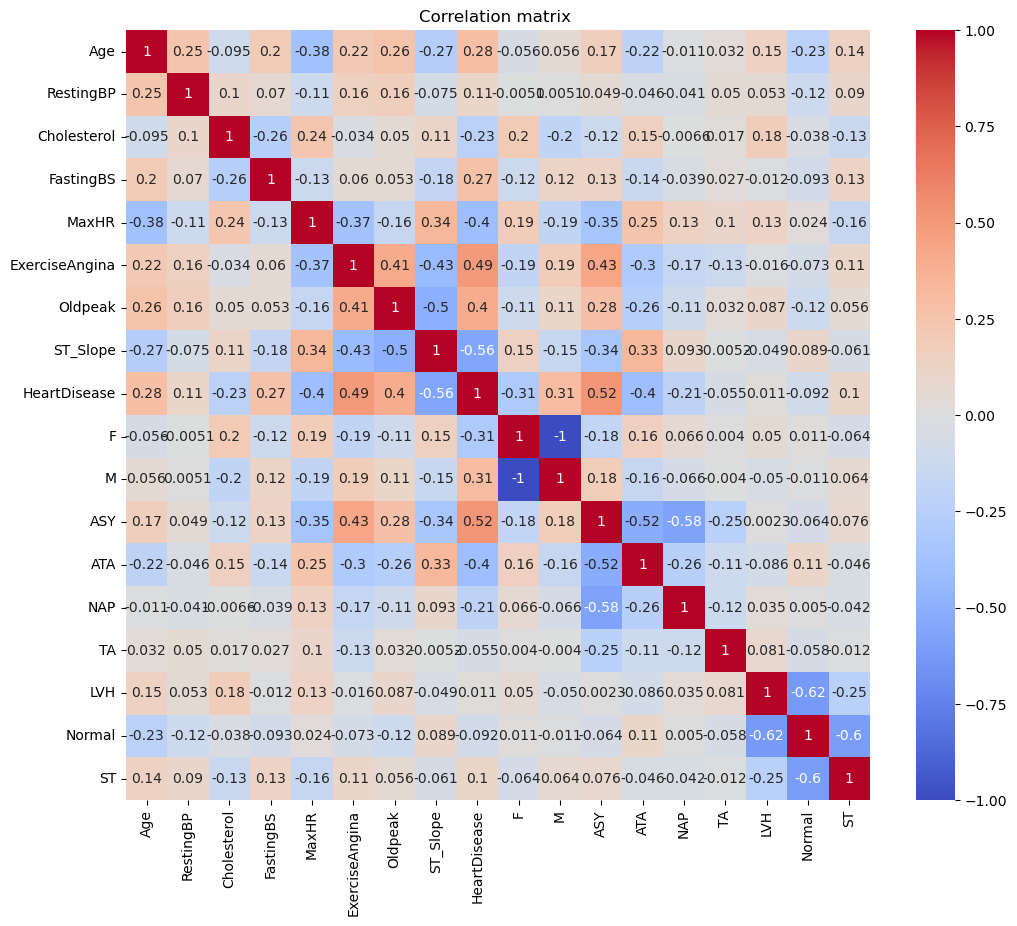

In [202]:
corr = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title("Correlation matrix ")
plt.show()

## 4. Data Transformation

### 4.1 Handle outliers

Winsorizing outliers instead of removing them to avoid losing samples (because our dataset is not so large)

In [203]:
def handle_outliers(data, cols):
    for col in cols: 
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        outliers = ((data[col] < lower_limit) | (data[col] > upper_limit)).sum()
        outlier_ratio = outliers / len(data)

        print(f"{col}: {outliers} outliers ({outlier_ratio:.2%})")

        if outlier_ratio <= 0.02 or col == 'Cholesterol':
            data[col] = winsorize(data[col], limits=[0.01, 0.01])
        elif outlier_ratio <= 0.10:
            data[col] = winsorize(data[col], limits=[0.05, 0.05])

    return data

In [204]:
data = handle_outliers(data, cols)
data

Age: 0 outliers (0.00%)
RestingBP: 28 outliers (3.05%)
Cholesterol: 183 outliers (19.93%)
MaxHR: 2 outliers (0.22%)
Oldpeak: 16 outliers (1.74%)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,F,M,ASY,ATA,NAP,TA,LVH,Normal,ST
0,40,140,289,0,172,0,0.0,2,0,False,True,False,True,False,False,False,True,False
1,49,160,180,0,156,0,1.0,1,1,True,False,False,False,True,False,False,True,False
2,37,130,283,0,98,0,0.0,2,0,False,True,False,True,False,False,False,False,True
3,48,138,214,0,108,1,1.5,1,1,True,False,True,False,False,False,False,True,False
4,54,150,195,0,122,0,0.0,2,0,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,0,1.2,1,1,False,True,False,False,False,True,False,True,False
914,68,144,193,1,141,0,3.4,1,1,False,True,True,False,False,False,False,True,False
915,57,130,131,0,115,1,1.2,1,1,False,True,True,False,False,False,False,True,False
916,57,130,236,0,174,0,0.0,1,1,True,False,False,True,False,False,True,False,False


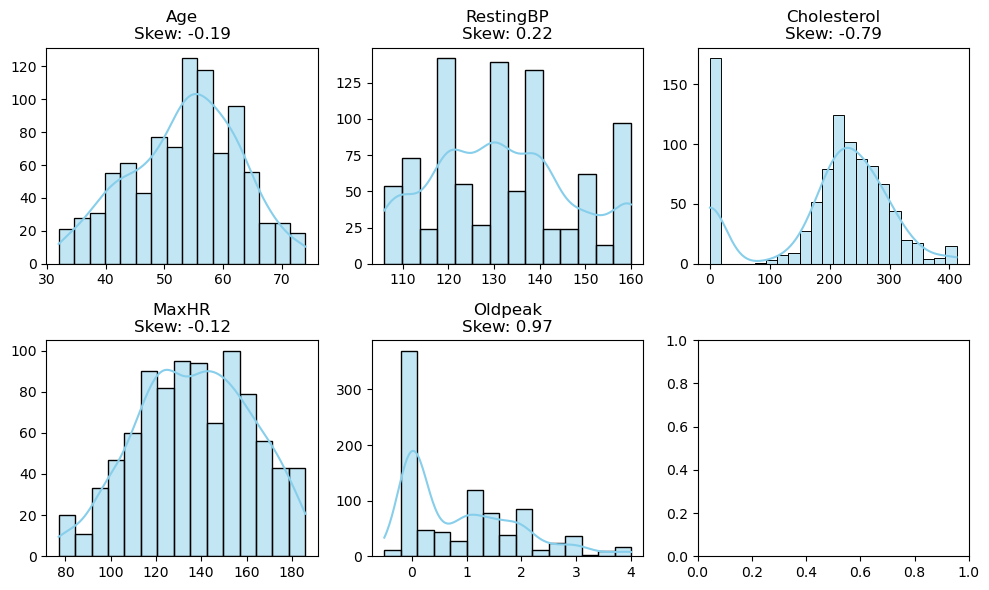

In [205]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()

for i, col in enumerate(cols):
    skew_val = data[col].skew()
    sns.histplot(data[col], kde=True, ax=ax[i], color='skyblue', alpha=0.5)
    ax[i].set_title(f"{col}\nSkew: {skew_val:.2f}")
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

### 4.2. Handle skewness

In [206]:
def handle_skewness(data, cols):
    for col in cols:
        try:
            lambda_opt = boxcox_normmax(data[col] + 1e-6)
            data[col] = boxcox1p(data[col], lambda_opt)
        except Exception as e:
            data[col] = np.log1p(data[col])
    return data

In [207]:
data = handle_skewness(data, cols)
data
data.isnull().sum()

c:\Users\vunha\miniconda3\envs\myenv\Lib\site-packages\scipy\stats\_morestats.py:1340: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)


Age               0
RestingBP         0
Cholesterol       0
FastingBS         0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
F                 0
M                 0
ASY               0
ATA               0
NAP               0
TA                0
LVH               0
Normal            0
ST                0
dtype: int64

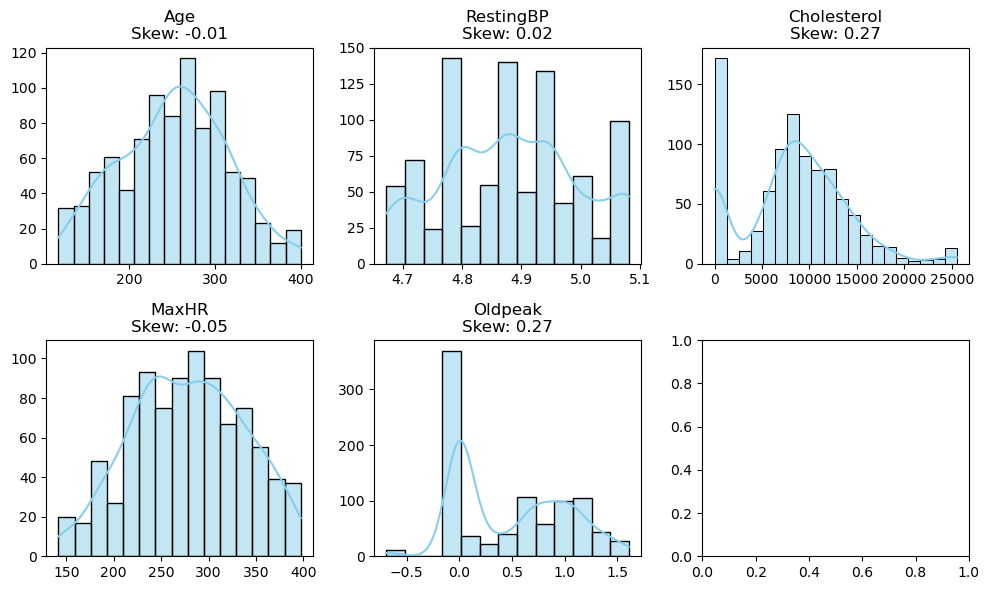

In [208]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()

for i, col in enumerate(cols):
    skew_val = data[col].skew()
    sns.histplot(data[col], kde=True, ax=ax[i], color='skyblue', alpha=0.5)
    ax[i].set_title(f"{col}\nSkew: {skew_val:.2f}")
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

### 4.3. Scaling

After handling skewness, every features is approximately normally distributed, StandardScaler is applied for all.

In [209]:
standardize = StandardScaler()

for col in cols:
    data[col] = standardize.fit_transform(data[[col]])

data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,F,M,ASY,ATA,NAP,TA,LVH,Normal,ST
0,-1.410907,0.561317,0.929253,0,1.418629,0,-0.953740,2,0,False,True,False,True,False,False,False,True,False
1,-0.519757,1.700117,-0.462374,0,0.758678,0,0.375363,1,1,True,False,False,False,True,False,False,True,False
2,-1.688618,-0.070243,0.839728,0,-1.526729,0,-0.953740,2,0,False,True,False,True,False,False,False,False,True
3,-0.622889,0.438667,-0.082735,0,-1.146326,1,0.803239,1,1,True,False,True,False,False,False,False,True,False
4,0.010581,1.149585,-0.301164,0,-0.603482,0,-0.953740,2,0,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.926228,-1.492553,0.565923,0,-0.208966,0,0.558120,1,1,False,True,False,False,False,True,False,True,False
914,1.617836,0.801483,-0.323236,1,0.150587,0,1.887223,1,1,False,True,True,False,False,False,False,True,False
915,0.340185,-0.070243,-0.917526,0,-0.876341,1,0.558120,1,1,False,True,True,False,False,False,False,True,False
916,0.340185,-0.070243,0.189663,0,1.501899,0,-0.953740,1,1,True,False,False,True,False,False,True,False,False


## 5. Train-test Split and Model Training

In [210]:
x = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
x

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,F,M,ASY,ATA,NAP,TA,LVH,Normal,ST
0,-1.410907,0.561317,0.929253,0,1.418629,0,-0.953740,2,False,True,False,True,False,False,False,True,False
1,-0.519757,1.700117,-0.462374,0,0.758678,0,0.375363,1,True,False,False,False,True,False,False,True,False
2,-1.688618,-0.070243,0.839728,0,-1.526729,0,-0.953740,2,False,True,False,True,False,False,False,False,True
3,-0.622889,0.438667,-0.082735,0,-1.146326,1,0.803239,1,True,False,True,False,False,False,False,True,False
4,0.010581,1.149585,-0.301164,0,-0.603482,0,-0.953740,2,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.926228,-1.492553,0.565923,0,-0.208966,0,0.558120,1,False,True,False,False,False,True,False,True,False
914,1.617836,0.801483,-0.323236,1,0.150587,0,1.887223,1,False,True,True,False,False,False,False,True,False
915,0.340185,-0.070243,-0.917526,0,-0.876341,1,0.558120,1,False,True,True,False,False,False,False,True,False
916,0.340185,-0.070243,0.189663,0,1.501899,0,-0.953740,1,True,False,False,True,False,False,True,False,False


In [211]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### 5.1. Logistic Regression

In [212]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [213]:
pred_lr = lr.predict(X_test)

In [214]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



### 5.2. Support Vector Machine

In [215]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC()

In [216]:
pred_svm = svm.predict(X_test)

In [217]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



### 5.3. Gradient Boosting

In [218]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [219]:
pred_gb = gb.predict(X_test)

In [220]:
print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



### 5.4. KNN

In [221]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [222]:
pred_knn = knn.predict(X_test)

In [223]:
print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



## 6. Hyperparameter Tuning

### 6.1. Individual models tuning

GridSearch is more suitable for dataset with fewer features and samples (because we can iterate through all the hyperparameter values), while RandomizedSearch prioritizes speed.

In [224]:
def train (model, param):
    grid_search = GridSearchCV(
        estimator = model,
        param_grid = param,
        scoring = 'accuracy',
        cv = KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
    )
    return grid_search.fit(X_train, y_train)

In [225]:
params_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear']
}

params_gb = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
}

params_knn = {
    'n_neighbors' : [5, 10, 15, 20, 25],
    'weights' : ['uniform', 'distance'],
}

In [226]:
svm_tuned = train(SVC(), params_svm)
print(classification_report(y_test, svm_tuned.predict(X_test)))
print("Best SVM params:", svm_tuned.best_params_)

gb_tuned = train(GradientBoostingClassifier(), params_gb)
print(classification_report(y_test, gb_tuned.predict(X_test)))
print("Best Gradient Boosting params:", gb_tuned.best_params_)

knn_tuned = train(KNeighborsClassifier(), params_knn)
print(classification_report(y_test, knn_tuned.predict(X_test)))
print("Best KNN params:", knn_tuned.best_params_)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

Best SVM params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184

Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        82
           1       0.91      0.89      0.90       102

    accuracy    

### 6.2. Stacking tuned models

In [227]:
models = [search.best_estimator_ for search in [svm_tuned, gb_tuned, knn_tuned]]

stacking_model = StackingClassifier(
    estimators = [
        ('svc', models[0]),
        ('gb', models[1]),
        ('knn', models[2]),
    ],
    final_estimator = RandomForestClassifier(n_estimators=100, random_state=42),
    cv = KFold(n_splits=5, shuffle=True, random_state=42),
    passthrough = True,
)

In [228]:
stacking_model.fit(X_train, y_train)
pred_stacking = stacking_model.predict(X_test)
print(classification_report(y_test, pred_stacking))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        82
           1       0.92      0.92      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184



## 7. Summary

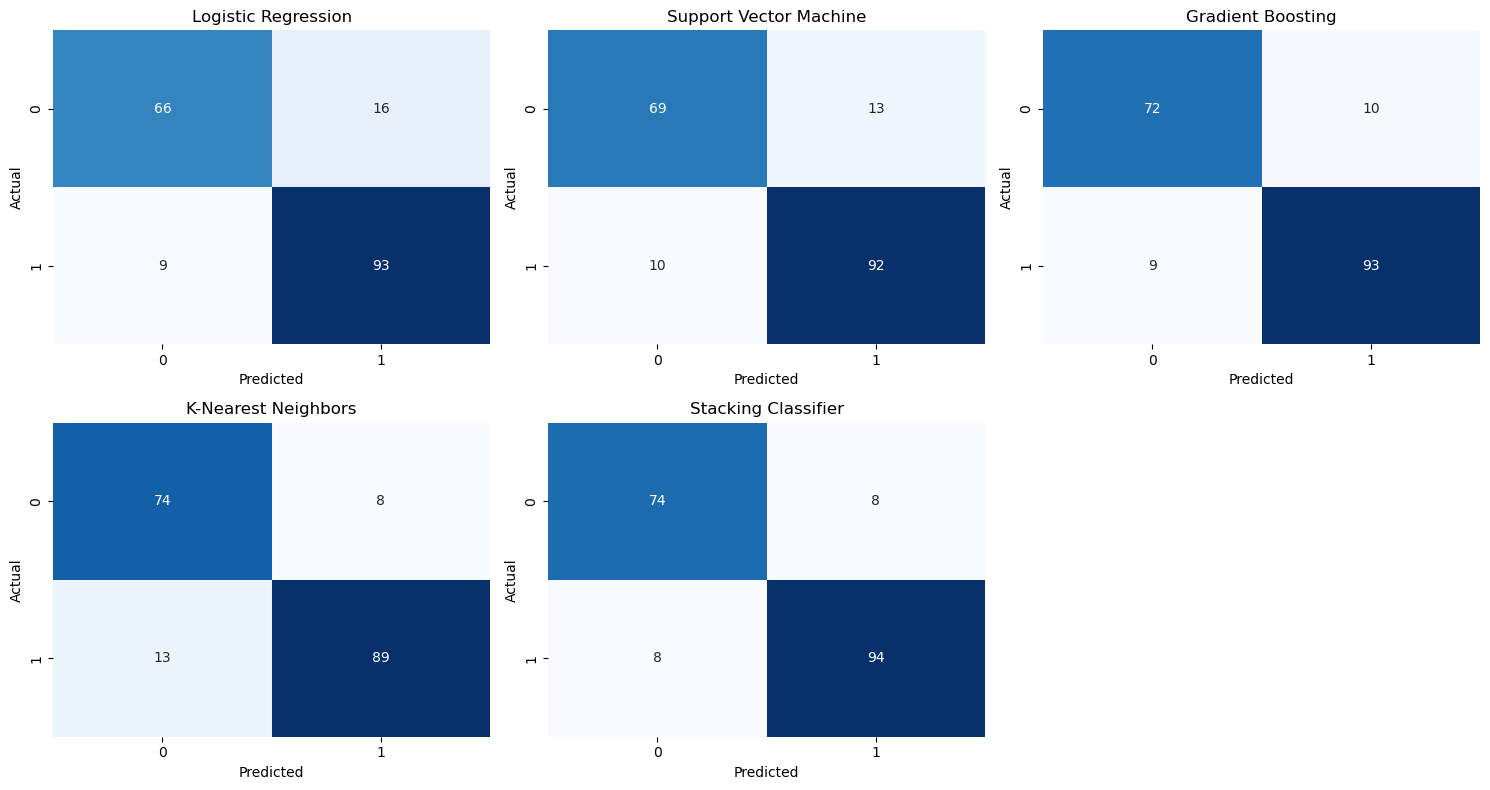

In [229]:
models = {
    'Logistic Regression': pred_lr,
    'Support Vector Machine': pred_svm,
    'Gradient Boosting': pred_gb,
    'K-Nearest Neighbors': pred_knn,
    'Stacking Classifier': pred_stacking
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

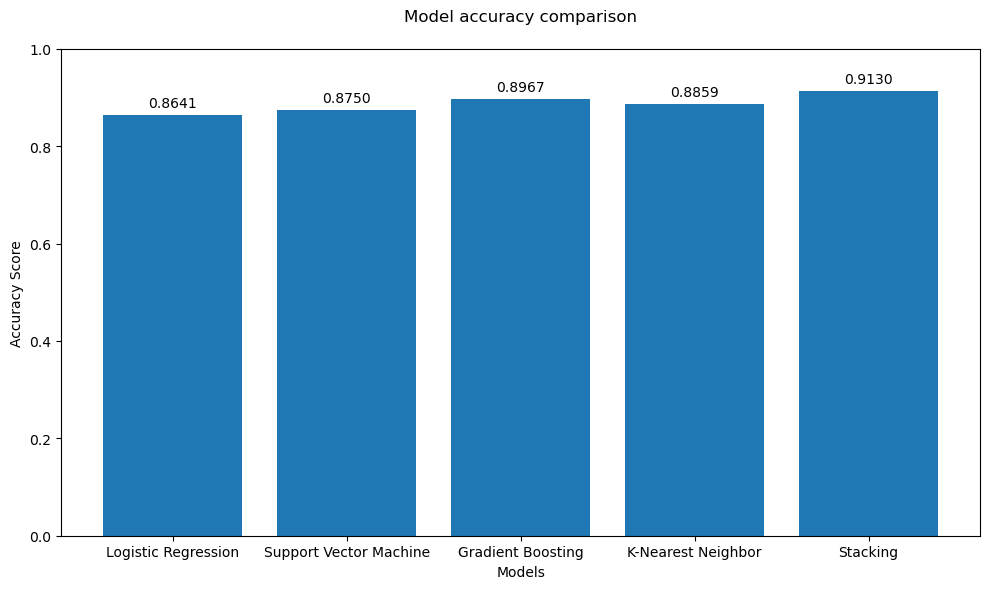

In [230]:
selected_models = ['Logistic Regression', 'Support Vector Machine', 'Gradient Boosting', 'K-Nearest Neighbor', 'Stacking']

scores = [accuracy_score(y_test, pred_lr),
          accuracy_score(y_test, pred_svm),
          accuracy_score(y_test, pred_gb),
          accuracy_score(y_test, pred_knn),
          accuracy_score(y_test, pred_stacking)]

plt.figure(figsize=(10, 6))
plt.bar(selected_models, scores)
plt.title('Model accuracy comparison', pad=20)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.tight_layout()

for i, v in enumerate(scores):
  plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.show()